<div style="background-color:#e8f4fd; padding:1em; border-radius:6px;">
<b>Notebook Disclaimer</b><br><br>
This notebook is part of the supporting material for the paper:<br>
<i>Modeling soil organic carbon changes using signal-to-noise analysis: a case study using European soil survey datasets.</i><br><br>
The figure and accompanying text are designed to be self-explanatory — you shouldn’t need to dive into the code to get the point :)<br>
But if you are curious about the implementation details, feel free to check the code blocks, too.
</div>

# Uncertainty Width Comparison

This notebook presents a comparison of the **width of uncertainty** (i.e., the spread or noise in predictions) estimated using two different approaches:

- **State-first approach**  
  Uncertainty is estimated by propagating the uncertainty from the predicted carbon states, $\hat{c}$.  
  For example, the uncertainty of the change between $\hat{c}_{t1}$ and $\hat{c}_{t2}$ is calculated as:

  $\sigma_{\Delta c} = \sqrt{\sigma^2_{\hat{c}_{t1}} + \sigma^2_{\hat{c}_{t2}}}$

- **Change-first approach**  
  Uncertainty is estimated directly from the corresponding Quantile Regression Forest (QRF) model trained on carbon changes.

---

## Objective

The goal of this comparison is to evaluate and contrast the estimated uncertainty **width** for both:

- **$\delta$** — representing the change component, and  
- **$\beta$** — representing the model coefficient or related metric.


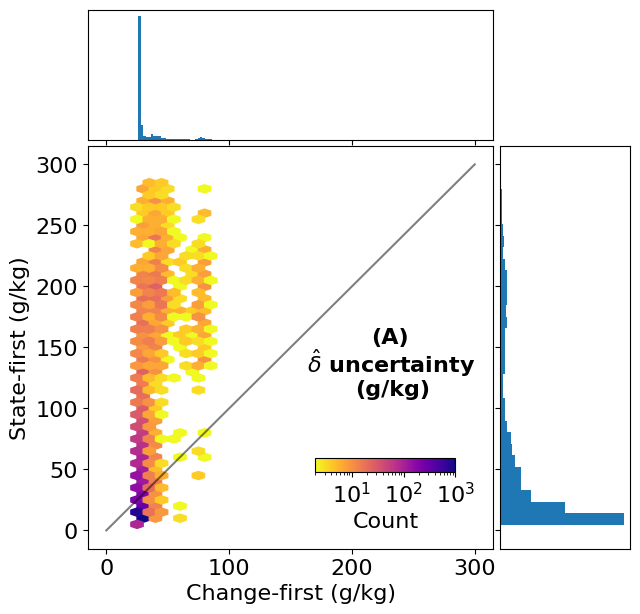

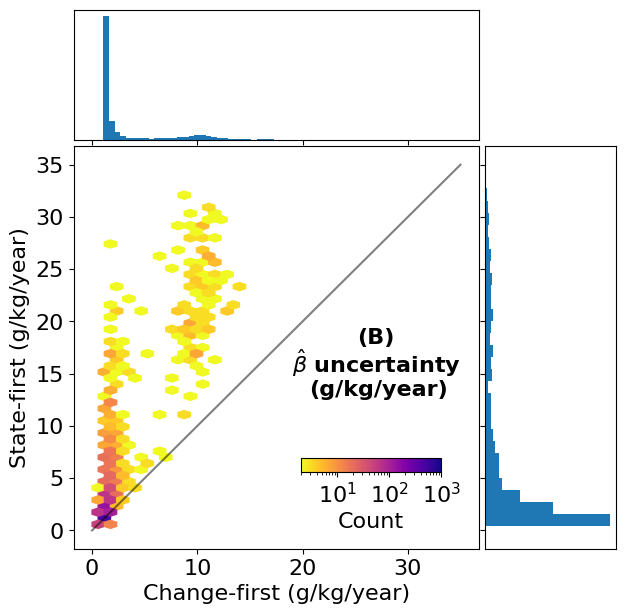

In [5]:
##################
# basic settings #
##################

version = 'v20250521'

import pandas as pd
from sklearn.model_selection import GroupKFold,cross_val_predict
from skmap.misc import find_files, GoogleSheet, ttprint
import joblib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# params
prop = 'change'
tgt = 'soc_change'
space = 'normal'


# # read in delta modelled by delta model
# pair = pd.read_parquet(f'./metric/pair_predicted.pnt_{version}.pq')
# pair = pair[['id', 'pred_pair', 'pred_std_pair', 'pred_change', 'noise', 'snr','time_pair','lc_survey_pair']]
# pair = pair.rename(columns={'pred_change':'pred_change_pnt', 'noise':'noise_pnt', 'snr':'snr_pnt'})
# pair['time_str'] = pair['time_pair'].str[0].astype(str)+'_'+pair['time_pair'].str[1].astype(str)

# # merge delta predicted by delta model and carbon model
# test = pd.read_parquet(f'./metric/pair_predicted.pair_{version}.pq')
# test = test[test.columns[0:12].tolist()+['soc_change','pred','pred_std']]
# test['time_str'] = test['time_pair'].str[0].astype(str)+'_'+test['time_pair'].str[1].astype(str)

# test = test.merge(pair, how='left', on=['id','time_str'])
# test.to_parquet(f'./metric/pair_predicted_{version}.pq')

###################################
# Compare uncertainty for \delta #
###################################

test = pd.read_parquet(f'./metric/pair_predicted_{version}.pq')


plt.rcParams.update({'font.size': 16})

# ---- figure & layout --------------------------------------------------------
fig = plt.figure(figsize=(7, 7))
gs  = gridspec.GridSpec(
        4, 4,                       # 4×4 grid
        hspace=0.05, wspace=0.05,   # tight spacing
)

ax_hex   = fig.add_subplot(gs[1:, :-1])  # main hexbin (rows 1-3, cols 0-2)
ax_xhist = fig.add_subplot(gs[0, :-1], sharex=ax_hex)  # top histogram
ax_yhist = fig.add_subplot(gs[1:, -1], sharey=ax_hex)  # right histogram

# ---- main hexbin ------------------------------------------------------------
show_range = [0, 300]
hb = ax_hex.hexbin(
        test['pred_std'], test['noise_pnt'],
        gridsize=(30, 30),
        extent=[*show_range, *show_range],
        cmap='plasma_r', mincnt=2, vmax=1000, bins='log'
)
ax_hex.plot(show_range, show_range, "-k", alpha=0.5)
ax_hex.set_xlabel('Change-first (g/kg)')
ax_hex.set_ylabel('State-first (g/kg)')
ax_hex.text(0.70, 0.55, '(A)', transform=ax_hex.transAxes,fontweight='bold', va='top')
ax_hex.text(0.54, 0.50, r'$\hat{\delta}$ uncertainty', transform=ax_hex.transAxes,fontweight='bold', va='top')
ax_hex.text(0.66, 0.42, r'(g/kg)', transform=ax_hex.transAxes,fontweight='bold', va='top')


# colour-bar
cbar_ax = fig.add_axes([0.45, 0.22, 0.2, 0.02])
cb = fig.colorbar(hb, cax=cbar_ax, orientation='horizontal')
cb.set_label('Count')

# ---- marginal histograms ----------------------------------------------------
bins = 30
ax_xhist.hist(test['pred_std'].dropna(), bins=bins, density=True, edgecolor='none')
ax_yhist.hist(test['noise_pnt'].dropna(), bins=bins, density=True,orientation='horizontal', edgecolor='none')
ax_xhist.tick_params(axis='y', which='both', left=False, labelleft=False)
ax_yhist.tick_params(axis='x', which='both', bottom=False, labelbottom=False)

ax_xhist.tick_params(axis='x', labelbottom=False)
ax_yhist.tick_params(axis='y', labelleft=False)

# plt.savefig(f'./figure/plot_mdl.compare_noise.{prop}.svg', bbox_inches='tight')
plt.show()


#################################
# Compare uncertainty for \beta #
#################################

test = pd.read_parquet(f'./metric/srs_predicted_{version}.pq')

plt.rcParams.update({'font.size': 16})

# ---- figure & layout --------------------------------------------------------
fig = plt.figure(figsize=(7, 7))
gs  = gridspec.GridSpec(
        4, 4,                       # 4×4 grid
        hspace=0.05, wspace=0.05,   # tight spacing
)

ax_hex   = fig.add_subplot(gs[1:, :-1])  # main hexbin (rows 1-3, cols 0-2)
ax_xhist = fig.add_subplot(gs[0, :-1], sharex=ax_hex)  # top histogram
ax_yhist = fig.add_subplot(gs[1:, -1], sharey=ax_hex)  # right histogram

# ---- main hexbin ------------------------------------------------------------
show_range = [0, 35]
hb = ax_hex.hexbin(
        test['pred_std'], test['slope_std'],
        gridsize=(30, 30),
        extent=[*show_range, *show_range],
        cmap='plasma_r', mincnt=2, vmax=1000, bins='log'
)
ax_hex.plot(show_range, show_range, "-k", alpha=0.5)
ax_hex.set_xlabel('Change-first (g/kg/year)')
ax_hex.set_ylabel('State-first (g/kg/year)')
ax_hex.text(0.70, 0.55, '(B)', transform=ax_hex.transAxes,fontweight='bold', va='top')
ax_hex.text(0.54, 0.50, r'$\hat{\beta}$ uncertainty', transform=ax_hex.transAxes,fontweight='bold', va='top')
ax_hex.text(0.58, 0.42, r'(g/kg/year)', transform=ax_hex.transAxes,fontweight='bold', va='top')

# colour-bar
cbar_ax = fig.add_axes([0.45, 0.22, 0.2, 0.02])
cb = fig.colorbar(hb, cax=cbar_ax, orientation='horizontal')
cb.set_label('Count')

# ---- marginal histograms ----------------------------------------------------
bins = 30
ax_xhist.hist(test['pred_std'].dropna(), bins=bins, density=True, edgecolor='none')
ax_yhist.hist(test['slope_std'].dropna(), bins=bins, density=True,orientation='horizontal', edgecolor='none')
ax_xhist.tick_params(axis='y', which='both', left=False, labelleft=False)
ax_yhist.tick_params(axis='x', which='both', bottom=False, labelbottom=False)

ax_xhist.tick_params(axis='x', labelbottom=False)
ax_yhist.tick_params(axis='y', labelleft=False)

plt.savefig(f'./figure/plot_mdl.compare_noise.{prop}.svg', bbox_inches='tight')
plt.show()


## Result Analysis

The two figures below (each generated by a separate code block) compare the uncertainties of $\hat{\delta}$ (A) and $\hat{\beta}$ (B), estimated using two approaches: **state-first** (y-axis) and **change-first** (x-axis).
Marginal histograms display the distributions of uncertainty from each approach along the top and right axes, respectively.

The **state-first approach** produces uncertainty estimates with both a higher mean and a larger spread for both $\hat{\delta}$ and $\hat{\beta}$ compared to the **change-first approach**.

However, the **lower end of the uncertainty distribution** from the change-first approach tends to be higher than that of the state-first approach—particularly for $\hat{\delta}$ predictions.

For both $\hat{\delta}$ and $\hat{\beta}$, even the minimum uncertainties exceed the typical magnitudes of these variables, which are close to zero because soil organic carbon (SOC) changes occur slowly.